# Quantitative Portfolio Risk Analyzer — **Spark SQL (Past Year + Next 6 Months)**


In [1]:
# %pip install pyspark pandas numpy matplotlib

In [ ]:
import os, time
from math import sqrt
from pathlib import Path
from datetime import date, timedelta
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PortfolioRisk_SQL_Future6M_Charts").getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

OUT_DIR = Path("outputs"); OUT_DIR.mkdir(exist_ok=True)

END_HIST = date.today()
DAYS_HIST = 252
PERIODS_FWD = 126
RF_DAILY = 0.0002
NOTIONAL = 1_000_000.0

assets = [
    ("SPY","SPDR S&P 500 ETF","USD",True,0.35),
    ("AGG","iShares Core U.S. Aggregate Bond ETF","USD",True,0.20),
    ("EFA","iShares MSCI EAFE ETF","USD",True,0.10),
    ("EEM","iShares MSCI EM ETF","USD",True,0.05),
    ("VNQ","Vanguard Real Estate ETF","USD",True,0.07),
    ("GLD","SPDR Gold Shares","USD",True,0.05),
    ("TLT","iShares 20+ Year Treasury Bond ETF","USD",True,0.08),
    ("QQQ","Invesco QQQ Trust","USD",True,0.07),
    ("SHY","iShares 1-3 Year Treasury Bond ETF","USD",True,0.03),
]

def gbm_path(start_price, drift, vol, n, seed):
    rng = np.random.default_rng(seed)
    dt = 1/252
    shocks = rng.normal((drift - 0.5*vol**2)*dt, vol*np.sqrt(dt), size=n)
    path = start_price * np.exp(np.cumsum(shocks))
    return np.round(path, 2)

params = {
    "SPY": (450, 0.07, 0.18, 1),
    "AGG": (100, 0.03, 0.06, 2),
    "EFA": (75,  0.05, 0.16, 3),
    "EEM": (40,  0.06, 0.22, 4),
    "VNQ": (90,  0.05, 0.20, 5),
    "GLD": (180, 0.03, 0.14, 6),
    "TLT": (95,  0.02, 0.12, 7),
    "QQQ": (380, 0.09, 0.28, 8),
    "SHY": (83,  0.025,0.02, 9),
}

dates_hist = pd.bdate_range(END_HIST - timedelta(days=DAYS_HIST), END_HIST)
dates_fwd = pd.bdate_range(start=END_HIST + timedelta(days=1), periods=PERIODS_FWD)

assets_df = pd.DataFrame([{"ticker":t,"name":nm,"currency":cur,"is_active":act} for (t,nm,cur,act,w) in assets])
portfolios_df = pd.DataFrame([{"name":"Well Rounded Portfolio","base_currency":"USD"}])

prices_records, last_hist_prices = [], {}
for t,_,_,_,_ in assets:
    sp,dr,vol,seed = params[t]
    path_hist = gbm_path(sp, dr, vol, len(dates_hist), seed)
    last_hist_prices[t] = float(path_hist[-1])
    for d, px in zip(dates_hist, path_hist):
        prices_records.append({"ticker": t, "trade_date": d, "close_price": float(px)})
for t,_,_,_,_ in assets:
    _,dr,vol,seed = params[t]
    fwd_seed = seed + 10
    path_fwd = gbm_path(last_hist_prices[t], dr, vol, len(dates_fwd), fwd_seed)
    for d, px in zip(dates_fwd, path_fwd):
        prices_records.append({"ticker": t, "trade_date": d, "close_price": float(px)})

prices_df = pd.DataFrame(prices_records)

last_hist_series = pd.Series(last_hist_prices)
positions_df = pd.DataFrame([
    {"portfolio_name":"Well Rounded Portfolio","ticker":t,"quantity":round((NOTIONAL*w)/float(last_hist_series[t]),4)}
    for (t,_,_,_,w) in assets
])

dates_all = pd.DatetimeIndex(sorted(set(prices_df["trade_date"])))
rf_df = pd.DataFrame({"rate_date":[d for d in dates_all], "daily_rate":[RF_DAILY]*len(dates_all)})

spark.createDataFrame(assets_df).createOrReplaceTempView("assets")
spark.createDataFrame(portfolios_df).createOrReplaceTempView("portfolios")
spark.createDataFrame(positions_df).createOrReplaceTempView("positions_src")
spark.createDataFrame(prices_df).createOrReplaceTempView("prices_src")
spark.createDataFrame(rf_df).createOrReplaceTempView("risk_free_rates")

print(f"Historical dates: {dates_hist[0].date()} .. {dates_hist[-1].date()}")
print(f"Forward dates:    {dates_fwd[0].date()} .. {dates_fwd[-1].date()}")

In [ ]:
# Tables via Spark SQL
spark.sql("""
WITH p AS (SELECT name, base_currency, ROW_NUMBER() OVER (ORDER BY name) AS portfolio_id FROM portfolios),
     a AS (SELECT ticker, ROW_NUMBER() OVER (ORDER BY ticker) AS asset_id FROM assets),
     pos AS (
       SELECT p.portfolio_id, p.name AS portfolio_name, a.asset_id, s.quantity
       FROM positions_src s JOIN p ON s.portfolio_name = p.name JOIN a ON s.ticker = a.ticker
     ),
     pr AS (
       SELECT a.asset_id, CAST(s.trade_date AS DATE) AS trade_date, s.close_price
       FROM prices_src s JOIN a ON s.ticker = a.ticker
     )
SELECT pos.portfolio_id, pos.portfolio_name, pr.trade_date, SUM(pos.quantity * pr.close_price) AS total_value
FROM pos JOIN pr ON pos.asset_id = pr.asset_id
GROUP BY pos.portfolio_id, pos.portfolio_name, pr.trade_date
""").createOrReplaceTempView("portfolio_daily_value")

spark.sql("""
SELECT portfolio_id, portfolio_name, trade_date,
       (total_value / LAG(total_value) OVER (PARTITION BY portfolio_id ORDER BY trade_date)) - 1.0 AS daily_return
FROM portfolio_daily_value
""").createOrReplaceTempView("portfolio_daily_returns")

spark.sql("""
WITH p AS (SELECT name, ROW_NUMBER() OVER (ORDER BY name) AS portfolio_id FROM portfolios),
     a AS (SELECT ticker, ROW_NUMBER() OVER (ORDER BY ticker) AS asset_id FROM assets),
     pos AS (
       SELECT p.portfolio_id, p.name AS portfolio_name, a.asset_id, a.ticker, s.quantity
       FROM positions_src s JOIN p ON s.portfolio_name = p.name JOIN a ON s.ticker = a.ticker
     ),
     pr AS (
       SELECT a.asset_id, a.ticker, CAST(s.trade_date AS DATE) AS trade_date, s.close_price
       FROM prices_src s JOIN a ON s.ticker = a.ticker
     )
SELECT pos.portfolio_id, pos.portfolio_name, pr.trade_date, pos.ticker, pos.quantity, pr.close_price,
       (pos.quantity * pr.close_price) AS position_value
FROM pos JOIN pr ON pos.asset_id = pr.asset_id
""").createOrReplaceTempView("portfolio_asset_daily_value")

spark.sql("""
WITH a AS (SELECT ticker, ROW_NUMBER() OVER(ORDER BY ticker) AS asset_id FROM assets),
spy AS (
  SELECT a.asset_id, a.ticker, CAST(s.trade_date AS DATE) AS trade_date, s.close_price
  FROM prices_src s JOIN a ON s.ticker = a.ticker
  WHERE a.ticker = 'SPY'
)
SELECT asset_id, ticker, trade_date,
       (close_price / LAG(close_price) OVER (PARTITION BY asset_id ORDER BY trade_date)) - 1.0 AS daily_return
FROM spy
""").createOrReplaceTempView("market_daily_returns")

spark.sql("""
WITH df AS (
  SELECT pdr.portfolio_id, pdr.portfolio_name, pdr.trade_date, pdr.daily_return,
         mdr.daily_return AS mkt_ret, COALESCE(rfr.daily_rate, 0.0) AS daily_rate
  FROM portfolio_daily_returns pdr
  JOIN market_daily_returns mdr ON pdr.trade_date = mdr.trade_date
  LEFT JOIN risk_free_rates rfr ON pdr.trade_date = rfr.rate_date
  WHERE pdr.daily_return IS NOT NULL AND mdr.daily_return IS NOT NULL
),
agg AS (
  SELECT portfolio_id, MAX(portfolio_name) AS portfolio_name, COUNT(*) AS trading_days,
         AVG(daily_return) AS mean_daily_ret, STDDEV_SAMP(daily_return) AS std_daily_ret,
         AVG(mkt_ret) AS mean_mkt_ret, COVAR_SAMP(daily_return, mkt_ret) AS cov_pr_mr,
         VAR_SAMP(mkt_ret) AS var_mr, AVG(daily_return - daily_rate) AS mean_excess,
         STDDEV_SAMP(daily_return - daily_rate) AS std_excess
  FROM df GROUP BY portfolio_id
),
hist_var AS (
  SELECT portfolio_id,
         -percentile_approx(daily_return, 0.05) AS var_hist_95,
         -percentile_approx(daily_return, 0.01) AS var_hist_99
  FROM df GROUP BY portfolio_id
)
SELECT a.portfolio_id, a.portfolio_name, a.trading_days, a.mean_daily_ret, a.std_daily_ret,
       (a.cov_pr_mr / a.var_mr) AS beta,
       (a.mean_daily_ret - (a.cov_pr_mr / a.var_mr) * a.mean_mkt_ret) AS beta_intercept,
       (a.mean_excess / a.std_excess) * SQRT(252) AS sharpe_annualized,
       h.var_hist_95, h.var_hist_99,
       -(a.mean_daily_ret + 1.6448536269514722 * a.std_daily_ret) AS var_param_95,
       -(a.mean_daily_ret + 2.3263478740408408 * a.std_daily_ret) AS var_param_99,
       (SELECT MAX(trade_date) FROM df d WHERE d.portfolio_id = a.portfolio_id) AS asof_date
FROM agg a JOIN hist_var h USING (portfolio_id)
""").createOrReplaceTempView("risk_metrics")

In [ ]:
# Save CSVs via Pandas (Windows-friendly)
OUT_DIR.mkdir(exist_ok=True)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

tables = ["portfolio_daily_value","portfolio_daily_returns","portfolio_asset_daily_value","market_daily_returns","risk_metrics"]
for t in tables:
    t0 = time.time()
    cnt = spark.sql(f"SELECT COUNT(*) AS n FROM {t}").collect()[0]["n"]
    print(f"[{t}] rows={cnt:,} — saving...")
    pdf = spark.sql(f"SELECT * FROM {t}").toPandas()
    pdf.to_csv(OUT_DIR / f"{t}.csv", index=False)
    print(f"[{t}] saved -> {OUT_DIR / f'{t}.csv'} in {time.time()-t0:.1f}s")
print("All CSVs written to:", OUT_DIR.resolve())

[portfolio_daily_value] rows=306 — saving...
[portfolio_daily_value] saved -> outputs\portfolio_daily_value.csv in 3.6s
[portfolio_daily_returns] rows=306 — saving...
[portfolio_daily_returns] saved -> outputs\portfolio_daily_returns.csv in 1.7s
[portfolio_asset_daily_value] rows=2,754 — saving...
[portfolio_asset_daily_value] saved -> outputs\portfolio_asset_daily_value.csv in 0.5s
[market_daily_returns] rows=306 — saving...
[market_daily_returns] saved -> outputs\market_daily_returns.csv in 0.6s
[risk_metrics] rows=1 — saving...
[risk_metrics] saved -> outputs\risk_metrics.csv in 3.1s
All CSVs written to: C:\Users\jatti\Downloads\outputs


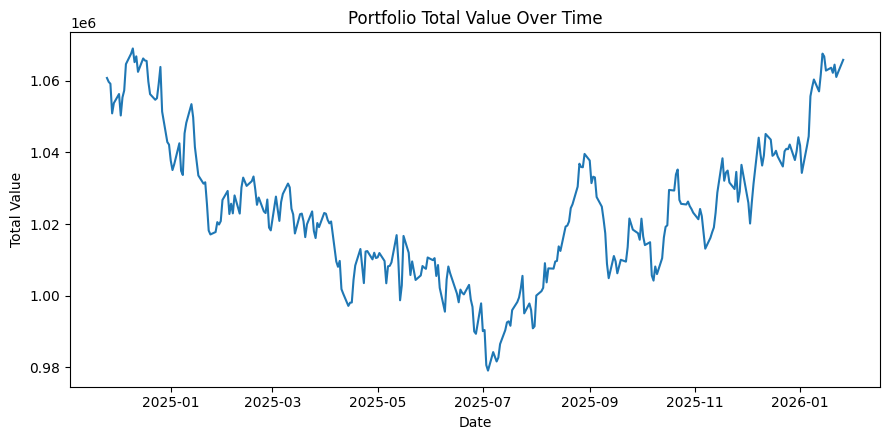

In [ ]:
# ---- Charts ----
import matplotlib.pyplot as plt
import pandas as pd

pv = spark.sql("SELECT trade_date, total_value FROM portfolio_daily_value ORDER BY trade_date").toPandas()
pv["trade_date"] = pd.to_datetime(pv["trade_date"])

plt.figure(figsize=(9,4.5))
plt.plot(pv["trade_date"], pv["total_value"])
plt.title("Portfolio Total Value Over Time")
plt.xlabel("Date")
plt.ylabel("Total Value")
plt.tight_layout()
plt.show()

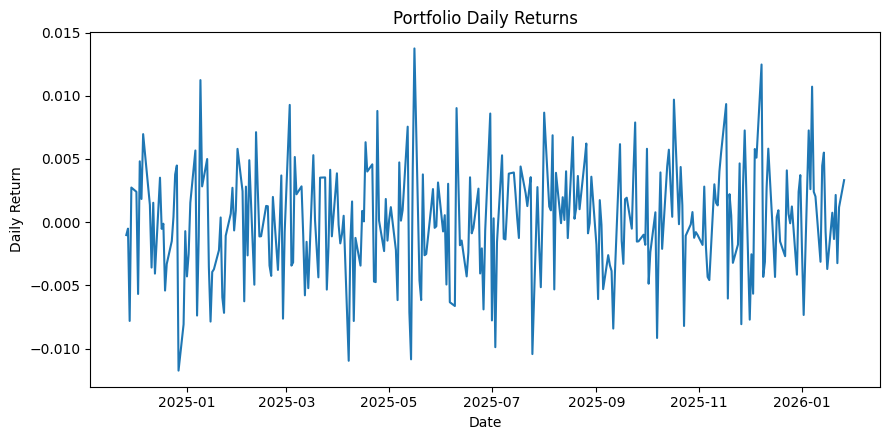

In [ ]:
rets = spark.sql("SELECT trade_date, daily_return FROM portfolio_daily_returns WHERE daily_return IS NOT NULL ORDER BY trade_date").toPandas()
rets["trade_date"] = pd.to_datetime(rets["trade_date"])

plt.figure(figsize=(9,4.5))
plt.plot(rets["trade_date"], rets["daily_return"])
plt.title("Portfolio Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.tight_layout()
plt.show()

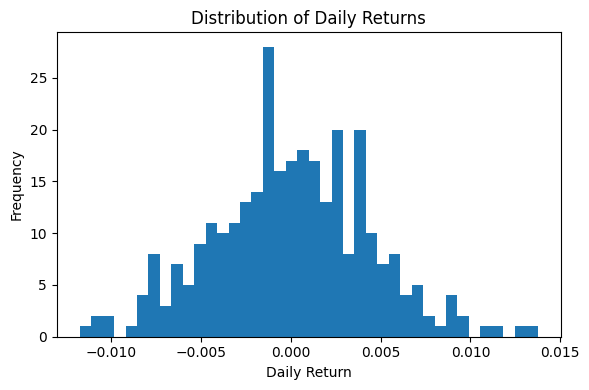

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(rets["daily_return"].dropna(), bins=40)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

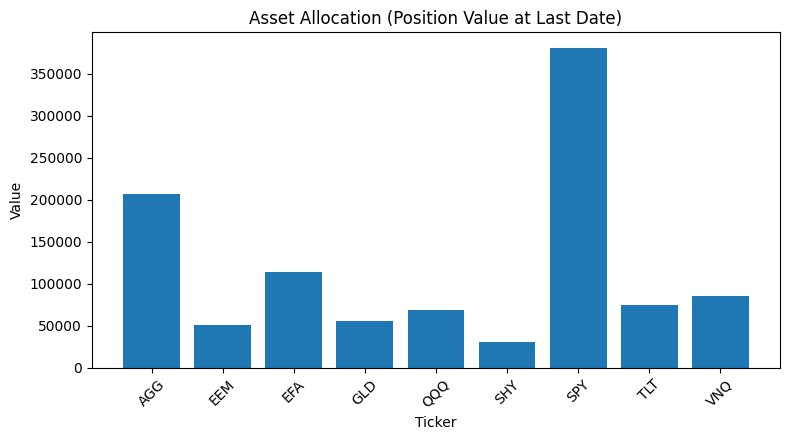

In [ ]:
padv = spark.sql("""
SELECT pa.ticker, pa.position_value
FROM portfolio_asset_daily_value pa
JOIN (SELECT MAX(trade_date) AS mx FROM portfolio_asset_daily_value) m
  ON pa.trade_date = m.mx
ORDER BY pa.ticker
""").toPandas()

plt.figure(figsize=(8,4.5))
plt.bar(padv["ticker"], padv["position_value"])
plt.title("Asset Allocation (Position Value at Last Date)")
plt.xlabel("Ticker")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Risk metrics table
risk_pdf = spark.sql("SELECT * FROM risk_metrics").toPandas()
display_cols = ["portfolio_name","asof_date","trading_days","beta","beta_intercept",
                "sharpe_annualized","var_hist_95","var_hist_99","var_param_95","var_param_99",
                "mean_daily_ret","std_daily_ret"]
risk_pdf = risk_pdf[display_cols]
risk_pdf

,portfolio_name,asof_date,trading_days,beta,beta_intercept,sharpe_annualized,var_hist_95,var_hist_99,var_param_95,var_param_99,mean_daily_ret,std_daily_ret
0,Well Rounded Portfolio,2026-01-26,305,0.363598,0.000045,-0.633985,0.007631,0.010432,-0.007226,-0.010209,0.000025,0.004378


In [ ]:
spark.stop()